<a id="top"></a>
# Cloud-Filtered Custom Mosaics

<hr>

# Notebook Summary

This notebook can be used to create custom Landsat cloud-filtered mosaics for any time period and location. The mosaics can be output as GeoTIFF products for analysis in external GIS tools. The following mosaics are possible:

Median = midpoint of spectral data  
Geomedian = Australian median product with improved spectral consistency  
Most-Recent = most-recent clear pixel  
Max-NDVI = maximum vegetation response

Users should review the [DCAL Cloud Statistics notebook](DCAL_Cloud_Statistics.ipynb) for more information about the cloud statistics for any given temporal and spatial combination. An understanding of the underlying data is important for creating a valid mosaic for further analyses. In many cases, cloud contamination will create poor mosaics. With a careful review of the cloud coverage over a given region and time period, it is possible to improve the mosaics and avoid false outputs.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Load and Clean Data from the Data Cube](#load_data)
* [Create Mosaics](#mosaics)
* [Create GeoTIFF Output Products](#export)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
# Enable importing of utilities.
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from utils.data_cube_utilities.dc_load import get_product_extents
from utils.data_cube_utilities.dc_time import dt_to_str
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils.data_cube_utilities.vegetation import NDVI
from utils.data_cube_utilities.dc_mosaic import \
    create_median_mosaic, create_hdmedians_multiple_band_mosaic, \
    create_mosaic, create_min_max_var_mosaic
from utils.data_cube_utilities.dc_rgb import rgb
from utils.data_cube_utilities.import_export import export_slice_to_geotiff

# Load Data Cube Configuration
import datacube
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = api.dc

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

**List available products for each platform**

In [2]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


Empty DataFrame
Columns: [platform, name]
Index: []

In [3]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


platform               name
id                              
1   LANDSAT_8  ls8_usgs_sr_scene

**Choose product**

<p style="color:red";><b>CHANGE INPUTS BELOW

In [4]:
# Select a Product and Platform
# Examples: ghana, kenya, tanzania, sierra_leone, senegal

# product = 'ls7_usgs_sr_scene'
# platform = 'LANDSAT_7'
# collection = 'c1'
# level = 'l2'

product = 'ls8_usgs_sr_scene'
platform = 'LANDSAT_8'
collection = 'c1'
level = 'l2'

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [5]:
full_lat, full_lon, min_max_dates = get_product_extents(api, platform, product)

# Print the extents of the combined data.
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, min_max_dates)))

Latitude Extents: (-6.8445833333880906, 9.723194444522232)
Longitude Extents: (-14.630416666783711, 44.009861111463195)
Time Extents: ['2013-04-12', '2020-01-24']


**Visualize the available area**

In [6]:
display_map(full_lat, full_lon)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [7]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# HINT: Keep your region small (<0.5 deg square) to avoid memory overload issues
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment

# Mombasa, Kenya
latitude = (-4.1, -3.9) 
longitude = (34.5, 34.7) 

# Freetown, Sierra Leone
# latitude = (8.3267, 8.5123)
# longitude = (-13.3109, -13.1197 )

# Tano-Offin Forest - Ghana
# latitude = (6.5814, 6.8978 ) 
# longitude = (-2.2955, -1.9395) 

# Vietnam
# latitude = (10.9358, 11.0358)
# longitude = (107.1899, 107.2899)

# Time Period
time_extents = ('2017-01-01', '2017-12-31')

**Visualize the selected area**

In [8]:
display_map(latitude,longitude)

## <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>

In [9]:
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [10]:
# Displays the first few values of each data array to check the content
# Latitude and Longitude numbers = number of pixels in each dimension
# Time = number of time slices in the dataset

landsat_dataset

<xarray.Dataset>
Dimensions:      (latitude: 721, longitude: 721, time: 67)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-01T07:50:22.393454 ... 2017-12...
  * latitude     (latitude) float64 -3.9 -3.9 -3.9 -3.901 ... -4.099 -4.1 -4.1
  * longitude    (longitude) float64 34.5 34.5 34.5 34.5 ... 34.7 34.7 34.7 34.7
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) int16 5980 5971 ... -9999 -9999
    green        (time, latitude, longitude) int16 5834 5823 ... -9999 -9999
    blue         (time, latitude, longitude) int16 5739 5708 ... -9999 -9999
    nir          (time, latitude, longitude) int16 6355 6346 ... -9999 -9999
    swir1        (time, latitude, longitude) int16 5786 5767 ... -9999 -9999
    swir2        (time, latitude, longitude) int16 4996 4970 ... -9999 -9999
    pixel_qa     (time, latitude, longitude) uint16 992 992 992 992 ... 1 1 1 1
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

>### Masking out Clouds

In [11]:
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform, 
                                   collection=collection, level=level)
cleaned_dataset = landsat_dataset.where(cloud_mask)

## <span id="mosaics">Create Mosaics [&#9652;](#top)</span>

In [12]:
common_rgb_params = dict(bands=['swir2', 'nir', 'green'], 
                         imshow_kwargs=dict(vmin=0, vmax=4000),
                         width=10)

> **Median Mosaic**  
>  Masks clouds from imagery using the median-valued cloud-free pixels in the time series.
>  More specifically, each band (e.g. red) of each pixel is assigned its median across time.
>  So this mosaic method generates values that are not in the dataset.

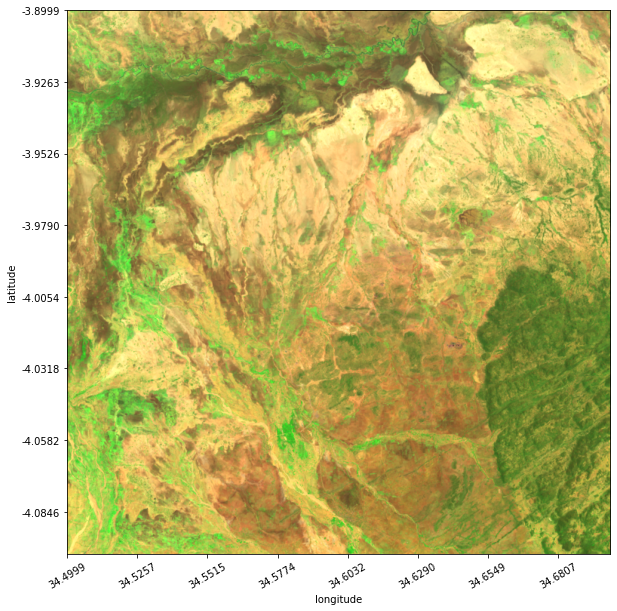

In [13]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

median_composite = create_median_mosaic(cleaned_dataset, cloud_mask)
rgb(median_composite, **common_rgb_params)
plt.show()

> **Geomedian Mosaic**  
>  Masks clouds from imagery using the geomedian-valued cloud-free pixels in the time series, which maintains the spectral band relationships. 
> That is, this is a median through time for all bands considered collectively rather than separately, as is the case in a median mosaic.
> This algorithm was developed by Geoscience Australia and produces excellent cloud-filtered mosaic products for further analysis. 
<br><br>
For more information, see the following paper: High-Dimensional Pixel Composites from Earth Observation Time Series, by, Dale Roberts, Norman Mueller, and Alexis McIntyre. IEEE Transactions on Geoscience and Remote Sensing, Vol. 55. No. 11, November 2017.

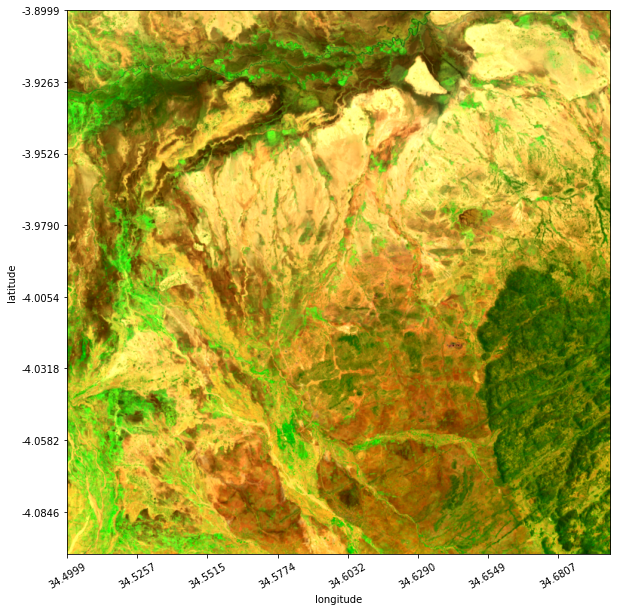

In [14]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

geomedian_composite = create_median_mosaic(cleaned_dataset, cloud_mask)
rgb(geomedian_composite, **common_rgb_params)
plt.show()

> **Most Recent and Least Recent Mosaic**  
>  Masks clouds from imagery using the most or least recent cloud-free pixels in the time series. 

**Most Recent Mosaic**

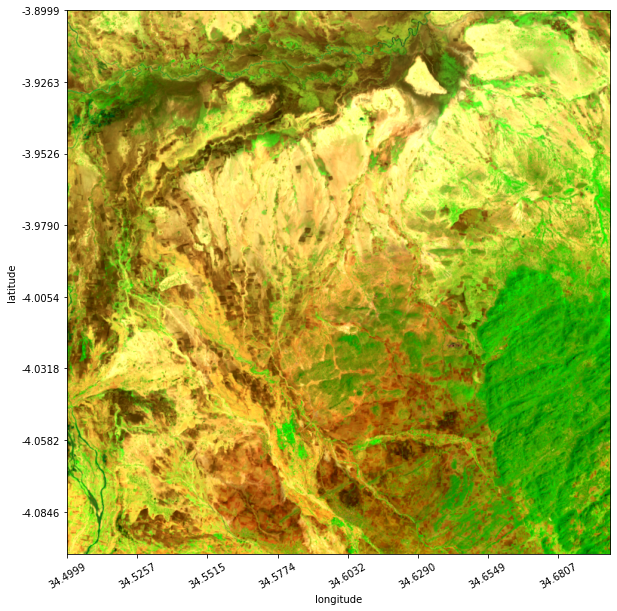

In [15]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

most_recent_composite = create_mosaic(cleaned_dataset, cloud_mask.values)
rgb(most_recent_composite, **common_rgb_params)
plt.show()

**Least Recent Mosaic**

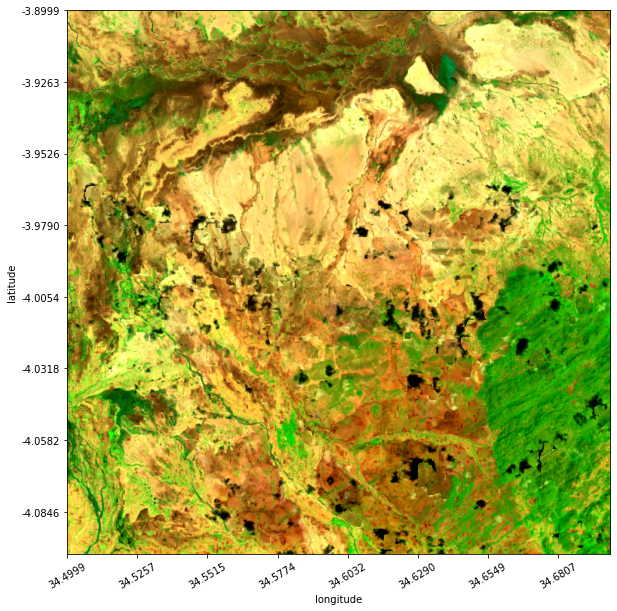

In [16]:
least_recent_composite = create_mosaic(cleaned_dataset, cloud_mask.values, reverse_time=True)
rgb(least_recent_composite, **common_rgb_params)
plt.show()

> **Max NDVI Mosaic**  
>  Masks clouds from imagery using the Max NDVI across time for cloud-free pixels in the time series. 

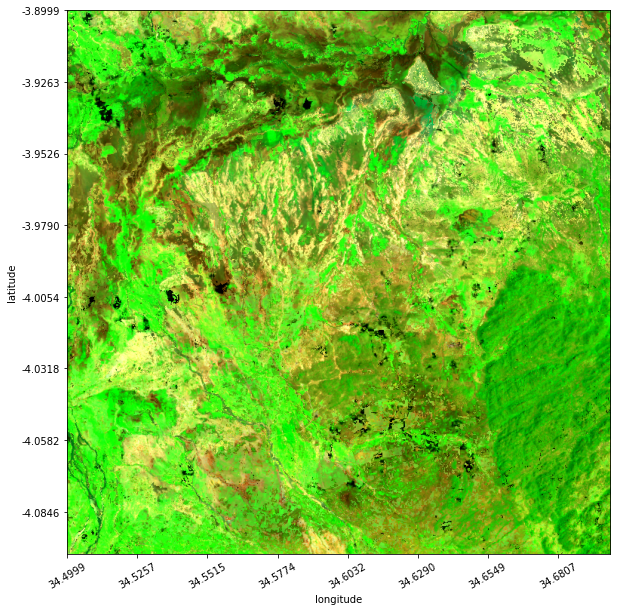

In [17]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

cleaned_dataset['NDVI'] = NDVI(cleaned_dataset)
max_ndvi_composite = create_min_max_var_mosaic(cleaned_dataset, cloud_mask, 
                                               var='NDVI', min_max='max')
rgb(max_ndvi_composite, **common_rgb_params)
plt.show()

## <span id="export">Create GeoTIFF Output Products [&#9652;](#top)</span>

In [18]:
# Remove the comment tags (#) to export a GeoTIFF output product
# Change the name of the output file, or it will be overwritten for each run 

output_dir = 'output/geotiffs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
export_slice_to_geotiff(median_composite, output_dir + '/DEMO_median_composite.tif')
# export_slice_to_geotiff(geomedian_composite, output_dir + '/DEMO_geomedian_composite.tif')
# export_slice_to_geotiff(most_recent_composite, output_dir + '/DEMO_most_recent_composite.tif')
# export_slice_to_geotiff(max_ndvi_composite, output_dir + '/DEMO_max_ndvi_composite.tif')

In [19]:
!ls -lah output/geotiffs/

total 24M
drwxr-xr-x 3 jovyan  1000 4.0K Feb  8 21:15 .
drwxr-xr-x 4 jovyan  1000 4.0K Feb  1 03:41 ..
-rw-r--r-- 1 jovyan users  14M Feb  8 21:15 DEMO_median_composite.tif
-rw-r--r-- 1 jovyan  1000 371K Sep 29 00:53 WOFS_Percentage.tif
drwxr-xr-x 2 jovyan  1000 4.0K Feb  8 20:16 custom_mosaics
-rw-r--r-- 1 jovyan  1000 9.0M Sep 25 20:16 sample_anomaly_01.tif
-rw-r--r-- 1 jovyan  1000 470K Sep 29 14:41 wofs.tif
